In [5]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# Define the symbolic variable t and H
t, H_sym = sp.symbols('t H')
# Define B and U as constants
B = sp.symbols('B')
U = sp.symbols('U')
# Define the control points
x0, y0 = 0, 0
x1, y1 = 0.1, 0.8
x2, y2 = 0.2, 0.9
x3, y3 = 1, 1

# Define the parametric equations for x(t) and y(t)
x_t = 3*t*(1 - t)**2 * x1 + 3*t**2*(1 - t) * x2 + t**3 * x3
y_t = 3*t*(1 - t)**2 * y1 + 3*t**2*(1 - t) * y2 + t**3 * y3

# Calculate the derivatives dx/dt and dy/dt
# Correct derivatives based on provided information
dx_dt = 3 * ((3 * t**2 - 4 * t + 1) * x1 + t * ((2 - 3 * t) * x2 + t * x3))
dy_dt = 3 * ((3 * t**2 - 4 * t + 1) * y1 + t * ((2 - 3 * t) * y2 + t * y3))

# Define the slope H as dy/dx
H = B * dy_dt / (dx_dt)

# Solve for t in terms of H
t_H = sp.solve(H - H_sym, t)

# Substitute t back into x(t) and y(t)
x_H = [x_t.subs(t, sol) for sol in t_H]
y_H = [y_t.subs(t, sol) for sol in t_H]

# Simplify the expressions
x_H = [sp.simplify(expr) for expr in x_H]
y_H = [sp.simplify(expr) for expr in y_H]

# Define p1 in terms of H, FPR (x_H), and TPR (y_H)
p1 = [(x * H_sym - U) / (x * H_sym + y * B) for x, y in zip(x_H, y_H)]

# Find the derivative of p1 with respect to H
dp1_dH = [sp.diff(expr, H_sym) for expr in p1]

# Convert expressions to lambda functions for numerical evaluation
p1_lambdas = [sp.lambdify((H_sym, B, U), expr, modules='numpy') for expr in p1]
dp1_dH_lambdas = [sp.lambdify((H_sym, B, U), expr, modules='numpy') for expr in dp1_dH]

# Define H range
# H_vals = np.linspace(0.0001, 0.7999, 10000)
H_vals = np.linspace(0, 10, 10000)

# Evaluate p1 and its derivative for a given B and U
B_val = 0.1  # Example value for B
U_val = 0  # Example value for U

# Initialize lists to store valid p1 and dp1/dH values
valid_p1_vals = []
valid_dp1_dH_vals = []

# two positive solutions for t_H, choose the positive one

In [2]:
# Define specific values for H and B
H_value = 0.5
B_value = 0.1

# Substitute H_sym with H_value and B with B_value in the equation H - H_sym = 0
H_substituted = H.subs({H_sym: H_value, B: B_value})

# Solve the equation H_substituted = H_value for t
t_H_solutions = sp.solve(H_substituted - H_value, t)

# Simplify the solutions
t_H_solutions_simplified = [sp.simplify(sol) for sol in t_H_solutions]

# Display the solutions
print(t_H_solutions_simplified)

# Compute x(t) and y(t) for each solution of t_H
x_H_values = [x_t.subs(t, sol) for sol in t_H_solutions_simplified]
y_H_values = [y_t.subs(t, sol) for sol in t_H_solutions_simplified]

# Simplify the expressions for x_H and y_H
x_H_simplified = [sp.simplify(x) for x in x_H_values]
y_H_simplified = [sp.simplify(y) for y in y_H_values]

# Display the results
x_H_simplified, y_H_simplified

[-0.661877235523957, 0.161877235523957]


([-0.401532479538176, 0.0515324795381763],
 [-2.71144577143864, 0.336445771438641])

In [6]:
# Filter solutions to include only those with positive x(t) and y(t)
valid_t_H_solutions = [
    sol for sol in t_H_solutions_simplified
    if x_t.subs(t, sol) > 0 and y_t.subs(t, sol) > 0
]

# Select the first valid solution
if valid_t_H_solutions:
    first_valid_t_H = valid_t_H_solutions[0]

    # Compute x(t) and y(t) for the first valid solution
    x_H_first_valid = sp.simplify(x_t.subs(t, first_valid_t_H))
    y_H_first_valid = sp.simplify(y_t.subs(t, first_valid_t_H))
else:
    x_H_first_valid = None
    y_H_first_valid = None

# If there's no valid solution, you might want to handle it accordingly
if x_H_first_valid is None or y_H_first_valid is None:
    raise ValueError("No valid positive solution for t_H was found.")

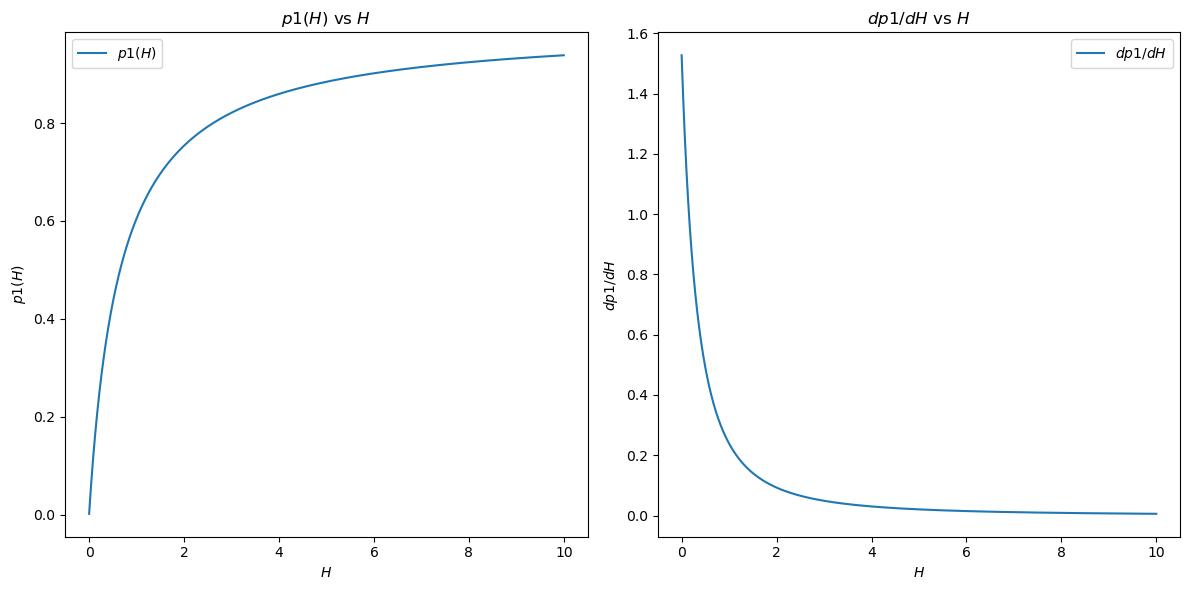

In [7]:
# Evaluate and filter out invalid values, considering only the first valid solution
valid_p1_vals = []
valid_dp1_dH_vals = []

if first_valid_t_H is not None:
    # Create lambdas for the first valid t_H solution
    p1_func = sp.lambdify((H_sym, B, U), (x_H_first_valid * H_sym - U) / (x_H_first_valid * H_sym + y_H_first_valid * B), modules='numpy')
    dp1_dH_func = sp.lambdify((H_sym, B, U), sp.diff((x_H_first_valid * H_sym - U) / (x_H_first_valid * H_sym + y_H_first_valid * B), H_sym), modules='numpy')

    # Evaluate p1 and its derivative
    p1_values = p1_func(H_vals, B_val, U_val)
    dp1_dH_values = dp1_dH_func(H_vals, B_val, U_val)

    # Filter out invalid (NaN) and negative values
    valid_indices = (
        ~np.isnan(p1_values) & 
        ~np.isnan(dp1_dH_values) & 
        np.isfinite(p1_values) & 
        np.isfinite(dp1_dH_values) & 
        (p1_values > 0) & 
        (dp1_dH_values > 0)
    )
    
    valid_p1_vals.append(p1_values[valid_indices])
    valid_dp1_dH_vals.append(dp1_dH_values[valid_indices])

# Plot p1 and its derivative
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for vals in valid_p1_vals:
    plt.plot(H_vals[:len(vals)], vals, label='$p1(H)$')
plt.title('$p1(H)$ vs $H$')
plt.xlabel('$H$')
plt.ylabel('$p1(H)$')
plt.legend()

plt.subplot(1, 2, 2)
for vals in valid_dp1_dH_vals:
    plt.plot(H_vals[:len(vals)], vals, label='$dp1/dH$')
plt.title('$dp1/dH$ vs $H$')
plt.xlabel('$H$')
plt.ylabel('$dp1/dH$')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate and filter out invalid values
for p1_func, dp1_dH_func in zip(p1_lambdas, dp1_dH_lambdas):
    p1_values = p1_func(H_vals, B_val, U_val)
#     print(p1_values[100:500])

    dp1_dH_values = dp1_dH_func(H_vals, B_val, U_val)
    
    # Filter out invalid (NaN) values
    valid_indices = ~np.isnan(p1_values) & ~np.isnan(dp1_dH_values) & np.isfinite(p1_values) & np.isfinite(dp1_dH_values)
    valid_p1_vals.append(p1_values[valid_indices])
    valid_dp1_dH_vals.append(dp1_dH_values[valid_indices])

# Plot p1 and its derivative
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for vals in valid_p1_vals:
    plt.plot(H_vals[:len(vals)], vals, label='$p1(H)$')
plt.title('$p1(H)$ vs $H$')
plt.xlabel('$H$')
plt.ylabel('$p1(H)$')
plt.legend()

plt.subplot(1, 2, 2)
for vals in valid_dp1_dH_vals:
    plt.plot(H_vals[:len(vals)], vals, label='$dp1/dH$')
plt.title('$dp1/dH$ vs $H$')
plt.xlabel('$H$')
plt.ylabel('$dp1/dH$')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
H

B*(7.2*t**2 + 3*t*(1.8 - 1.7*t) - 9.6*t + 2.4)/(1.8*t**2 + 3*t*(0.8 - 0.2*t) - 2.4*t + 0.6)

In [96]:
t_H[0]

(B - 1.13389341902768*sqrt(-0.111111111111111*B**2 + B*H - 0.111111111111111*H**2))/(B - H)

In [99]:
x_H[0]

(0.7*B**3 + 2.1*B**2*H - 2.60795486376367*B**2*sqrt(-0.111111111111111*B**2 + B*H - 0.111111111111111*H**2) + 1.94289029309402e-16*B*H**2 - 0.340168025708304*B*H*sqrt(-0.111111111111111*B**2 + B*H - 0.111111111111111*H**2) - 0.226778683805536*H**2*sqrt(-0.111111111111111*B**2 + B*H - 0.111111111111111*H**2))/(1.0*B**3 - 3.0*B**2*H + 3.0*B*H**2 - 1.0*H**3)

In [93]:
p1_func(0.799, 0.1, 0)

0.48286453022009207

In [94]:
p1_lambdas, dp1_dH_lambdas

([<function _lambdifygenerated(H, B, U)>,
  <function _lambdifygenerated(H, B, U)>],
 [<function _lambdifygenerated(H, B, U)>,
  <function _lambdifygenerated(H, B, U)>])

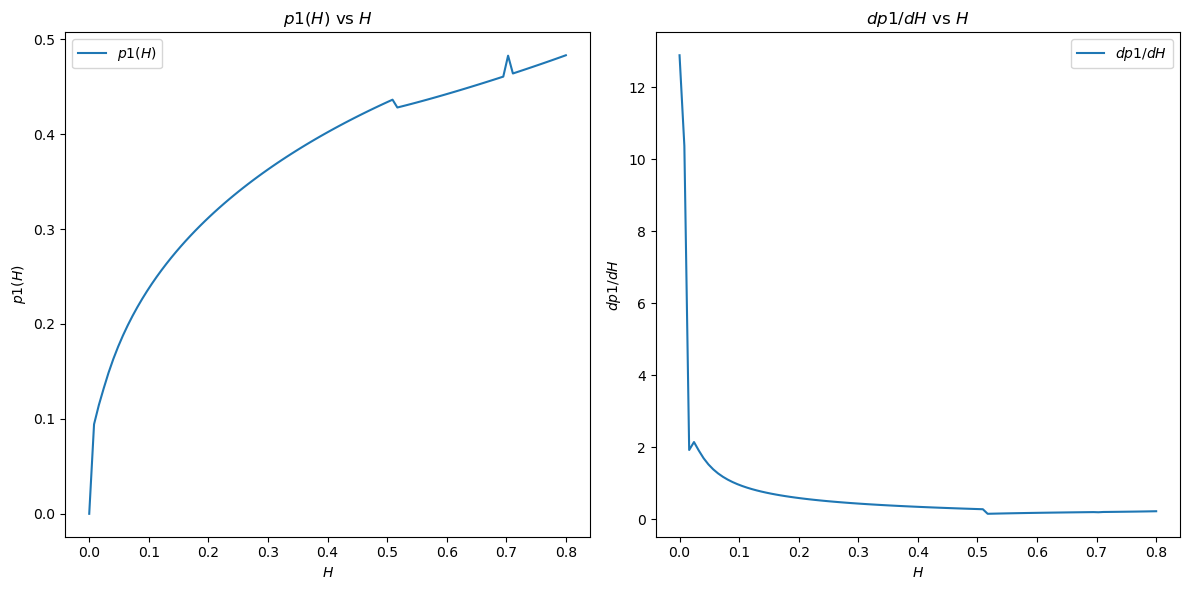

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Define the control points
x0, y0 = 0, 0
x1, y1 = 0.1, 0.8
x2, y2 = 0.2, 0.9
x3, y3 = 1, 1

# Define the parametric equations for x(t) and y(t)
def x_t(t):
    return 3 * t * (1 - t)**2 * x1 + 3 * t**2 * (1 - t) * x2 + t**3 * x3

def y_t(t):
    return 3 * t * (1 - t)**2 * y1 + 3 * t**2 * (1 - t) * y2 + t**3 * y3

# Define the derivatives dx/dt and dy/dt
def dx_dt(t):
    return 3 * ((3 * t**2 - 4 * t + 1) * x1 + t * ((2 - 3 * t) * x2 + t * x3))

def dy_dt(t):
    return 3 * ((3 * t**2 - 4 * t + 1) * y1 + t * ((2 - 3 * t) * y2 + t * y3))

# Define the slope H as dy/dx
def H_func(t):
    return B * dy_dt(t) / (dx_dt(t) + 0.0000001)

# Solve for t in terms of H using numerical methods
def solve_t(H_val):
    func = lambda t: H_func(t) - H_val
    t_initial_guess = 0.5
    t_solution = fsolve(func, t_initial_guess)
    return t_solution[0]

# Define B and U as constants
B = 0.1  # Example value for B
U = 0  # Example value for U

# Define p1 in terms of H, FPR (x_H), and TPR (y_H)
def p1(H_val):
    t_val = solve_t(H_val)
    FPR = x_t(t_val)
    TPR = y_t(t_val)
    return (FPR * H_val - U) / (FPR * H_val + TPR * B)

# Define the derivative of p1 with respect to H numerically
def dp1_dH(H_val):
    epsilon = 1e-5
    return (p1(H_val + epsilon) - p1(H_val - epsilon)) / (2 * epsilon)

# Define H range
H_vals = np.linspace(0, 0.8, 100)

# Evaluate p1 and its derivative for the given range of H
p1_vals = np.array([p1(H) for H in H_vals])
dp1_dH_vals = np.array([dp1_dH(H) for H in H_vals])

# Plot p1 and its derivative
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(H_vals, p1_vals, label='$p1(H)$')
plt.title('$p1(H)$ vs $H$')
plt.xlabel('$H$')
plt.ylabel('$p1(H)$')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(H_vals, dp1_dH_vals, label='$dp1/dH$')
plt.title('$dp1/dH$ vs $H$')
plt.xlabel('$H$')
plt.ylabel('$dp1/dH$')
plt.legend()

plt.tight_layout()
plt.show()
